In [2]:
# load the libraries

import sys
sys.path.append('../')

import numpy as np
import math
import os
import glob
import matplotlib.pyplot as plt
import scipy.io as sio
import cv2
import json
import openslide

import torch
import torchvision.transforms as transforms
sys.path.append('../seg-ed')

import unet

In [3]:
seg_image_path = '/home/ret58/rds/hpc-work/epithelium_slides/images/'
seg_label_path = '/home/ret58/rds/hpc-work/epithelium_slides/masks/'

mat_file_path = '/home/ret58/rds/hpc-work/epithelium_slides_1266/kumar/mat/'
overlay_file_path = '/home/ret58/rds/hpc-work/epithelium_slides_1266/kumar/overlay/'
json_file_path = '/home/ret58/rds/hpc-work/epithelium_slides_1266/kumar/json/'

model_path = '/home/ret58/rds/hpc-work/seg_epi/UNet_20220629_150835/model'

386


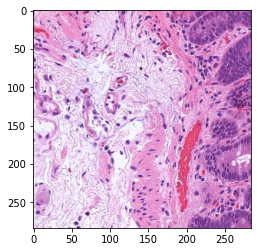

(284, 284, 3)
torch.Size([3, 284, 284])
Device set to: cpu.
tensor([  0, 255])


In [4]:
seg_image_list = glob.glob(seg_image_path + '1266*.png')
seg_image_list.sort()
print(len(seg_image_list))

# get a random image 
rand_nr = np.random.randint(0,len(seg_image_list))
image_file = seg_image_list[rand_nr]

image = cv2.imread(image_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

transform = transforms.ToTensor()
image_t = transform(image)

print(image.shape)
print(image_t.shape)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device set to: {DEVICE}.")

model = torch.load(model_path, map_location=DEVICE)

with torch.no_grad():
# get prediction from image
    img_gpu = torch.unsqueeze(image_t,0).to(DEVICE)
    output = model(img_gpu).softmax(dim=1)
    img_pred = output.to("cpu")

img_pred = 255 * torch.argmax(img_pred, dim=1)
print(img_pred.unique())

(1136, 1136)


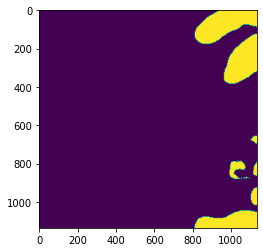

In [5]:
# Scale image to 4x in each dimension
resize = transforms.Resize((1136,1136), interpolation=transforms.InterpolationMode.NEAREST)

epi_mask = resize(img_pred)
 
epi_mask = epi_mask.numpy().squeeze()
print(epi_mask.shape)
#print(np.unique(epi_mask.unique))

# Let's see the image
plt.imshow(epi_mask)
plt.show()

In [6]:
print(image_file)

basename = os.path.basename(image_file)
image_ext = basename.split('.')[-1]
basename = basename[:-(len(image_ext)+1)]

# get the corresponding `.mat` file 
result_mat = sio.loadmat(mat_file_path + basename + '.mat')
inst_map = result_mat['inst_map']
inst_centroid = result_mat['inst_centroid']
inst_centroid_pix = np.around(inst_centroid).astype(int)
inst_uid = result_mat['inst_uid']

#print(result_mat.keys())
#print(inst_map.shape)
#print(len(np.unique(inst_map)))
#print(inst_centroid_pix.shape)
#print(len(inst_uid))

epi_nuc_centroid = []
epi_nuc_uid = []

for inst, centroid in enumerate(inst_centroid_pix):
    #### WHY DOES IT ONLY WORK THIS WAY ROUND??? ###
    if epi_mask[centroid[1], centroid[0]] == 255:
        epi_nuc_centroid.append((centroid[1], centroid[0]))
        epi_nuc_uid.append(inst_uid[inst][0])

print(epi_nuc_uid)
#print(epi_nuc_centroid)


/home/ret58/rds/hpc-work/epithelium_slides/images/1266_15_39760_5112.png
[4, 5, 7, 9, 11, 12, 15, 17, 18, 19, 21, 22, 25, 26, 29, 31, 32, 33, 35, 41, 42, 43, 44, 47, 48, 50, 51, 56, 57, 60, 61, 62, 64, 65, 78, 79, 80, 83, 84, 85, 87, 90, 93, 95, 98, 101, 103, 109, 111, 116, 118, 124, 125, 126, 127, 130, 132, 133, 136, 137, 140, 142, 143, 144, 145, 147, 149, 152, 154, 156, 157, 160, 161, 163, 164, 166, 168, 169, 172, 173, 177, 181, 287, 330, 336, 339, 342, 349, 369, 383, 384, 420, 421, 422, 424, 425, 428, 429, 430, 432, 434, 436, 437, 438, 439, 440, 441, 442, 443, 444, 447, 448, 449, 450, 451, 453, 456, 457, 458]


460
0
119
(1136, 1136)


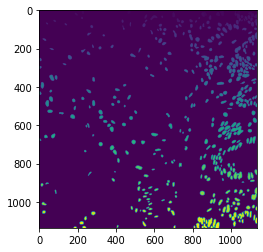

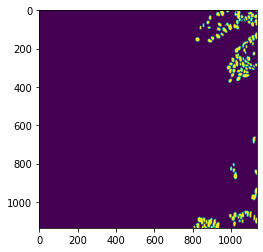

In [7]:
def include_pixel(pixel_id, nucleus_ids):
    if pixel_id in nucleus_ids:
        return pixel_id
    return 0

# Jim suggested passing in a dictionary.
#def include_pixel(pixel_id_and_nuc_ids):
#    if pixel_id_and_nuc_ids["a"] in pixel_id_and_nuc_ids["b"]:
#        return pixel_id_and_nuc_ids["a"]
#    return 0

#num_rows, num_cols = inst_map.shape
#epi_nuclei = np.zeros((num_rows, num_cols), int)

#for i in range(num_rows):
#    for j in range(num_cols):
#        if inst_map[i, j] in epi_nuc_uid:
#            epi_nuclei[i, j] = inst_map[i, j]

#print(np.nditer(inst_map))

print(len(np.unique(inst_map)))
print(inst_map[0,0])
print(len(np.unique(epi_nuc_uid)))

# Does not work
#epi_nuclei = np.asarray([list(map(include_pixel, roworcol, epi_nuc_uid)) for roworcol in inst_map])

# Works but slow
epi_nuclei = np.asarray([[include_pixel(y, epi_nuc_uid) for y in x] for x in inst_map])

#print([set(roworcol) for roworcol in epi_nuclei])
print(epi_nuclei.shape)

epi_nuclei_bw = epi_nuclei
epi_nuclei_bw[epi_nuclei_bw > 0] = 255
epi_nuclei_bw = np.asarray(epi_nuclei_bw)

plt.imshow(inst_map)
plt.show()

plt.imshow(epi_nuclei_bw)
plt.show()

In [9]:
basename = os.path.basename(image_file)
image_ext = basename.split('.')[-1]
basename = basename[:-(len(image_ext)+1)]

json_path = json_file_path + basename + '.json'

bbox_list = []
centroid_list = []
contour_list = [] 
type_list = []

with open(json_path) as json_file:
    data = json.load(json_file)
    mag_info = data['mag']
    nuc_info = data['nuc']
    print(list(nuc_info.keys()))
    
    #for inst in nuc_info:
    for uid in epi_nuc_uid:  
        inst_info = nuc_info[str(uid)]
        inst_centroid = inst_info['centroid']
        centroid_list.append(inst_centroid)
        inst_contour = inst_info['contour']
        contour_list.append(inst_contour)
        inst_bbox = inst_info['bbox']
        bbox_list.append(inst_bbox)

print(centroid_list[0:3])
print(len(contour_list))

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '

CV2 Ellipse Fitting!!

First tuple is centre of bounding rectangle

Second tuple is width, height of bounding rectangle (width >= height)

Number is rotation angle, degrees

Area calc seems to be working.

[[559, 531], [558, 532], [557, 532], [555, 534], [555, 537], [557, 539], [557, 540], [558, 541], [558, 542], [562, 542], [563, 543], [566, 543], [567, 544], [573, 544], [574, 543], [576, 543], [577, 542], [577, 541], [578, 540], [578, 539], [577, 538], [577, 537], [575, 535], [575, 534], [574, 534], [572, 532], [570, 532], [569, 531]]
230.5
((566.2700805664062, 537.3289184570312), (12.993005752563477, 23.52008628845215), 102.25719451904297)


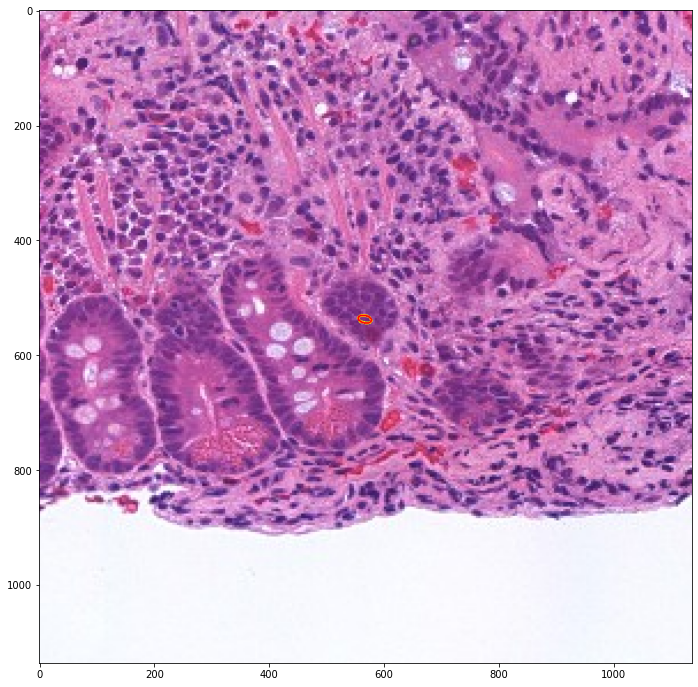

In [30]:
rand_nucleus = np.random.randint(0, len(centroid_list))
rand_centroid = centroid_list[rand_nucleus]
rand_bbox = bbox_list[rand_nucleus]
rand_contour = contour_list[rand_nucleus]

print(rand_contour)
print(cv2.contourArea(np.array(rand_contour)))
print(cv2.fitEllipse(np.array(rand_contour)))
rand_ellipse = cv2.fitEllipse(np.array(rand_contour))
rand_area = cv2.contourArea(np.array(rand_contour))

width = image.shape[1] * 4
height = image.shape[0] * 4
dim = (width, height)
  
# resize image
overlay = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
overlay = cv2.drawContours(overlay.astype('uint8'), [np.array(rand_contour)], -1, (255,255,0), 3)
overlay = cv2.ellipse(overlay.astype('uint8'), rand_ellipse, (255,0,0), 2)

plt.figure(figsize = (12,12))
plt.imshow(overlay)
plt.show()

In [34]:
## Make a data frame and add measurements to it?
## Or make lists and combine them into data frame?
max_diam = rand_ellipse[1][0]
min_diam = rand_ellipse[1][1]
diam_ratio = rand_area
ellipse_area = math.pi * 0.5 * max_diam * 0.5 * min_diam

print(max_diam, min_diam, diam_ratio, ellipse_area)

12.993005752563477 23.52008628845215 230.5 240.01502129767184
